# Import Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

# Load CIFAR-10 Dataset

In [ ]:
def dataloader_cifar():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    # Input Data in Local Machine
    # train_dataset = datasets.CIFAR10('../input_data', train=True, download=True, transform=transform)
    # test_dataset = datasets.CIFAR10('../input_data', train=False, download=True, transform=transform)
    
    # Input Data in Google Drive
    train_dataset = datasets.CIFAR10('/content/CIFAR10', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('/content/CIFAR10', train=False, download=True, transform=transform)

    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))
    
    print("Image shape of a random sample image : {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    
    print("Training Set:   {} images".format(len(train_dataset)))
    print("Validation Set:   {} images".format(len(val_dataset)))
    print("Test Set:       {} images".format(len(test_dataset)))
    
    BATCH_SIZE = 32

    # Generate dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)
    
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = dataloader_cifar()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/CIFAR10/cifar-10-python.tar.gz to /content/CIFAR10
Files already downloaded and verified
Image shape of a random sample image : (3, 32, 32)

Training Set:   45000 images
Validation Set:   5000 images
Test Set:       10000 images


# Define ResNet

In [ ]:
class LambdaLayer(nn.Module):
    
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    
    def forward(self, x):
        return self.lambd(x)

class BasicConvBlock(nn.Module):
    
    ''' The BasicConvBlock takes an input with in_channels, applies some blocks of convolutional layers 
    to reduce it to out_channels and sum it up to the original input. 
    If their sizes mismatch, then the input goes into an identity. 
    
    Basically The BasicConvBlock will implement the regular basic Conv Block + 
    the shortcut block that does the dimension matching job (option A or B) when dimension changes between 2 blocks
    '''
    
    def __init__(self, in_channels, out_channels, stride=1, option='A'):
        super(BasicConvBlock, self).__init__()
        
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(out_channels)),
            ('act1', nn.ReLU()),
            ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(out_channels))
        ]))

        self.shortcut = nn.Sequential()
        
        '''  When input and output spatial dimensions don't match, we have 2 options, with stride:
            - A) Use identity shortcuts with zero padding to increase channel dimension.    
            - B) Use 1x1 convolution to increase channel dimension (projection shortcut).
         '''
        if stride != 1 or in_channels != out_channels:
            if option == 'A':
                # Use identity shortcuts with zero padding to increase channel dimension.
                pad_to_add = out_channels//4
                ''' ::2 is doing the job of stride = 2
                F.pad apply padding to (W,H,C,N).
                
                The padding lengths are specified in reverse order of the dimensions,
                F.pad(x[:, :, ::2, ::2], (0,0, 0,0, pad,pad, 0,0))

                [width_beginning, width_end, height_beginning, height_end, channel_beginning, channel_end, batchLength_beginning, batchLength_end ]

                '''
                self.shortcut = LambdaLayer(lambda x:
                            F.pad(x[:, :, ::2, ::2], (0,0, 0,0, pad_to_add, pad_to_add, 0,0)))
            if option == 'B':
                self.shortcut = nn.Sequential(OrderedDict([
                    ('s_conv1', nn.Conv2d(in_channels, 2*out_channels, kernel_size=1, stride=stride, padding=0, bias=False)),
                    ('s_bn1', nn.BatchNorm2d(2*out_channels))
                ]))
        
    def forward(self, x):
        out = self.features(x)
        # sum it up with shortcut layer
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    """
        ResNet-56 architecture for CIFAR-10 Dataset of shape 32*32*3
    """
    def __init__(self, block_type, num_blocks):
        super(ResNet, self).__init__()
        
        self.in_channels = 32
        
        self.conv0 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.block1 = self.__build_layer(block_type, 32, num_blocks[0], starting_stride=1)
        
        self.block2 = self.__build_layer(block_type, 64, num_blocks[1], starting_stride=2)
        
        self.block3 = self.__build_layer(block_type, 128, num_blocks[2], starting_stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(128, 10)
    
    def __build_layer(self, block_type, out_channels, num_blocks, starting_stride):
        
        strides_list_for_current_block = [starting_stride] + [1]*(num_blocks-1)
        ''' Above line will generate an array whose first element is starting_stride
        And it will have (num_blocks-1) more elements each of value 1
         '''
        # print('strides_list_for_current_block ', strides_list_for_current_block)
        
        layers = []
        
        for stride in strides_list_for_current_block:
            layers.append(block_type(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        out = self.block1(out)
        out = self.block2(out)        
        out = self.block3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [ ]:
def ResNet56():
    return ResNet(block_type=BasicConvBlock, num_blocks=[9,9,9])

In [ ]:
# Summarize the model
model = ResNet56()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu'
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
    BasicConvBlock-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
   BasicConvBlock-14           [-1, 32,

In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

# Training

In [ ]:
def train_model():
    EPOCHS = 20
    train_samples_num = 45000
    val_samples_num = 5000
    train_costs, val_costs = [], []
    
    #Training phase.    
    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0
        
        model.train().cuda()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
            to zero before starting to do backpropragation """
            optimizer.zero_grad()
            
            # Start the forward pass
            prediction = model(inputs)
                        
            loss = criterion(prediction, labels)
          
            # do backpropagation and update weights with step()
            loss.backward()         
            optimizer.step()
            
            # print('outputs on which to apply torch.max ', prediction)
            # find the maximum along the rows, use dim=1 to torch.max()
            _, predicted_outputs = torch.max(prediction.data, 1)
            
            # Update the running corrects 
            correct_train += (predicted_outputs == labels).float().sum().item()
            
            ''' Compute batch loss
            multiply each average batch loss with batch-length. 
            The batch-length is inputs.size(0) which gives the number total images in each batch. 
            Essentially I am un-averaging the previously calculated Loss '''
            train_running_loss += (loss.data.item() * inputs.shape[0])


        train_epoch_loss = train_running_loss / train_samples_num
        
        train_costs.append(train_epoch_loss)
        
        train_acc =  correct_train / train_samples_num

        # Now check trained weights on the validation set
        val_running_loss = 0
        correct_val = 0
      
        model.eval().cuda()
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)

                # Compute validation accuracy.
                _, predicted_outputs = torch.max(prediction.data, 1)
                correct_val += (predicted_outputs == labels).float().sum().item()

            # Compute batch loss.
            val_running_loss += (loss.data.item() * inputs.shape[0])

            val_epoch_loss = val_running_loss / val_samples_num
            val_costs.append(val_epoch_loss)
            val_acc =  correct_val / val_samples_num
        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        
        print(info.format(epoch+1, EPOCHS, train_epoch_loss, train_acc, val_epoch_loss, val_acc))
        
        torch.save(model.state_dict(), '/content/checkpoint_gpu_{}'.format(epoch + 1)) 
                                                                
    torch.save(model.state_dict(), '/content/resnet-56_weights_gpu')  
        
    return train_costs, val_costs

In [ ]:
train_costs, val_costs = train_model()

[Epoch 1/20]: train-loss = 1.540441 | train-acc = 0.436 | val-loss = 0.001678 | val-acc = 0.454
[Epoch 2/20]: train-loss = 0.995146 | train-acc = 0.647 | val-loss = 0.000313 | val-acc = 0.668
[Epoch 3/20]: train-loss = 0.733681 | train-acc = 0.744 | val-loss = 0.000497 | val-acc = 0.758
[Epoch 4/20]: train-loss = 0.580947 | train-acc = 0.799 | val-loss = 0.001083 | val-acc = 0.807
[Epoch 5/20]: train-loss = 0.472329 | train-acc = 0.836 | val-loss = 0.000968 | val-acc = 0.802
[Epoch 6/20]: train-loss = 0.383236 | train-acc = 0.867 | val-loss = 0.000175 | val-acc = 0.831
[Epoch 7/20]: train-loss = 0.303840 | train-acc = 0.896 | val-loss = 0.000864 | val-acc = 0.842
[Epoch 8/20]: train-loss = 0.239448 | train-acc = 0.917 | val-loss = 0.000172 | val-acc = 0.842
[Epoch 9/20]: train-loss = 0.177990 | train-acc = 0.937 | val-loss = 0.002207 | val-acc = 0.823
[Epoch 10/20]: train-loss = 0.143272 | train-acc = 0.951 | val-loss = 0.000369 | val-acc = 0.853
[Epoch 11/20]: train-loss = 0.112370 | 

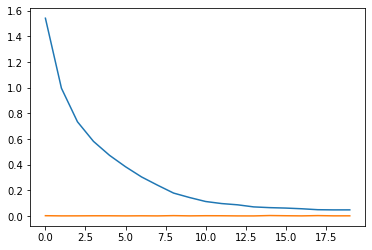

In [16]:
# Plot the train and validation losses
import matplotlib.pyplot as plt
plt.plot(train_costs)
plt.plot(val_costs)

In [ ]:
#Restore the model.
model = ResNet56()
model.load_state_dict(torch.load('/content/resnet-56_weights_gpu'))

<All keys matched successfully>

# Test the trained model on Test dataset

In [ ]:
test_samples_num = 10000
correct = 0 

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples_num
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8403
